In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

def generate_pow_chan(power_profile_dB):
    power_profile=10**(0.1*power_profile_dB)
    return np.array(\
                    [(np.random.normal(0.0, 0.5*power_profile[index]) + \
                     (1.0j)*np.random.normal(0.0, 0.5*power_profile[index]))\
                     for index in range(power_profile.shape[0])])

def generate_frequency_dependent_chan(delay_profile, chan_pow):
    L=delay_profile.shape[0]
    U = lambda f: ((np.exp(-1.0j*2*np.pi*f*delay_profile))*(chan_pow)).sum(axis=0)
    return U

# Sim Params
macroBSTx=43
femtoBSTx=15
macroUETx=25
femtoUETx=10
D12=1000
R1=200
N0_Hz=-174
macro_loss=lambda R: 128.1+37.6*np.log10(R/1000)
Lv=6.9
femto_loss=lambda R,n: 37 + 32*np.log10(R)+n*Lv
fading_const=8

# Frequency Array
center_frequency=0.0
bandwidth_macro=2e+6
start_frequency_macro=center_frequency-(bandwidth_macro/2)
end_frequency_macro=center_frequency+(bandwidth_macro/2)
bandwidth_femto=1e+6
start_frequency_femto=center_frequency-(bandwidth_femto/2)
end_frequency_femto=center_frequency+(bandwidth_femto/2)
#----------------------------------------------------------------------
# FFT Params
number_bins=64
N_subcarrier_macro=64
bins_left_edges=np.linspace(start_frequency_macro, end_frequency_macro, num=(number_bins+1))[:number_bins]
bin_size=bins_left_edges[1]-bins_left_edges[0]
freq_arr_macro=bins_left_edges+(bin_size/2)
number_bins=32
N_subcarrier_femto=32
bins_left_edges=np.linspace(start_frequency_femto, end_frequency_femto, num=(number_bins+1))[:number_bins]
bin_size=bins_left_edges[1]-bins_left_edges[0]
freq_arr_femto=bins_left_edges+(bin_size/2)
#----------------------------------------------------------------------

chan_power_V=np.array([0,-1.5,-1.4,-3.6,-0.6,-9.1,-7.0,-12.0,-16.9]) #in dB
chan_delay_V=np.array([0,30,150,310,370,710,1090,1730,2510])# in ns
chan_power_P=np.array([0,-1.0,-2.0,-3.0,-8.0, -17.2,-20.8]) # in dB
chan_delay_P=np.array([0,30,70,90,110,190,410]) #in ns

chan_pow_P=generate_pow_chan(chan_power_P)
chan_pow_V=generate_pow_chan(chan_power_V)

freq_chan_P=generate_frequency_dependent_chan(chan_delay_P,chan_pow_P)
freq_chan_V=generate_frequency_dependent_chan(chan_delay_V,chan_pow_V)

femto_list_P=np.array(list(map(freq_chan_P, freq_arr_femto)))
femto_list_V=np.array(list(map(freq_chan_V, freq_arr_femto)))
macro_list_P=np.array(list(map(freq_chan_P, freq_arr_macro)))
macro_list_V=np.array(list(map(freq_chan_V, freq_arr_macro)))

# print(macro_list_P.shape)
# print(femto_list_P.shape)

# Cell Scenario

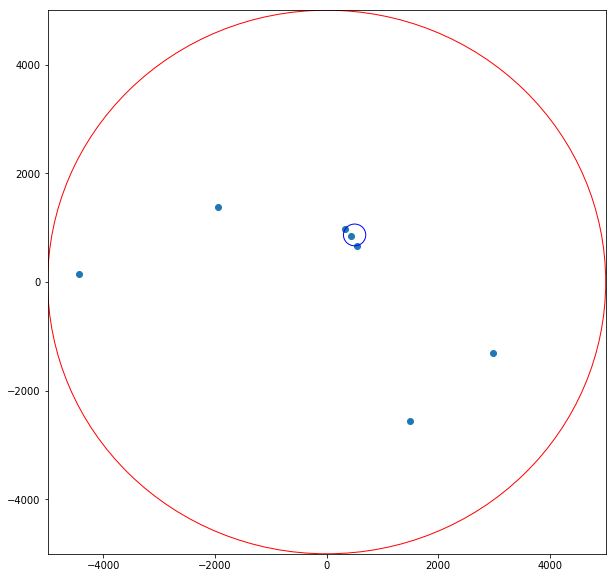

In [4]:
femto_center_x=500
femto_center_y=500*np.sqrt(3)
macro_radius=5000
def plot_scenario():
    circle1 = plt.Circle((0, 0), macro_radius, color='r', fill=False)
    circle2 = plt.Circle((femto_center_x, femto_center_y), R1, color='blue', fill=False)
    ax.add_artist(circle1)
    ax.add_artist(circle2)

def do_random_placement(plot=True):
    theta_femto=(np.random.rand()*360)*np.pi/180
    femto_radii=np.random.rand()*0.75*R1
    theta_macro=(np.random.rand(4)*280+80)*np.pi/180
    var_radii=np.random.rand(4)*macro_radius
    theta_boundary=(np.random.rand(2)*360)*np.pi/180
    bound_radii=np.random.rand(2)*(0.1*R1)+R1
    pts_x=[femto_center_x+femto_radii*np.cos(theta_femto) if i==0 else\
           ((femto_center_x+bound_radii[i-1]*np.cos(theta_boundary[i-1])) if i<3 else\
           var_radii[i-3]*np.cos(theta_macro[i-3])) for i in range(7)]
    
    pts_y=[femto_center_y+femto_radii*np.sin(theta_femto) if i==0 else\
           ((femto_center_y+bound_radii[i-1]*np.sin(theta_boundary[i-1])) if i<3 else\
           var_radii[i-3]*np.sin(theta_macro[i-3])) for i in range(7)]
    pts=np.array(list(zip(pts_x,pts_y)))
    if(plot==True):
        ax.scatter(pts_x,pts_y)
    return pts_x,pts_y,pts

plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()
ax.set_xlim((-macro_radius, macro_radius))
ax.set_ylim((-macro_radius, macro_radius))    
plot_scenario()
do_random_placement(True)
plt.show()

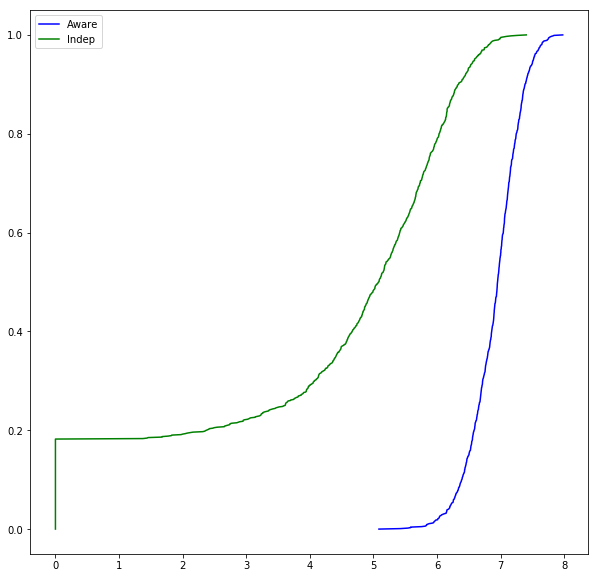

In [3]:
macroUETx=25
femtoUETx=10

CQI_v_Rate=[1.46,2.35,3.75,5.47,7.34,9.21,11.94,15.02,17.04,20.73,24.35,28.23,31.92,34.66]

def CDF(data,col,label_txt):
    sorted_data = np.sort(data)
    yvals=np.arange(len(sorted_data))/float(len(sorted_data)-1)
    plt.plot(sorted_data,yvals,color=col,label=label_txt)

def get_chan_params(femto=True,pedestrian=True):
    if(femto==True and pedestrian== True):
        chan_pow_P=generate_pow_chan(chan_power_P)
        freq_chan_P=generate_frequency_dependent_chan(chan_delay_P,chan_pow_P)
        femto_list_P=np.abs(np.array(list(map(freq_chan_P, freq_arr_femto))))
        return femto_list_P
    if(femto==False and pedestrian==True):
        chan_pow_P=generate_pow_chan(chan_power_P)
        freq_chan_P=generate_frequency_dependent_chan(chan_delay_P,chan_pow_P)
        macro_list_P=np.abs(np.array(list(map(freq_chan_P, freq_arr_macro))))
        return macro_list_P
    if(femto==True and pedestrian==False):
        chan_pow_V=generate_pow_chan(chan_power_V)
        freq_chan_V=generate_frequency_dependent_chan(chan_delay_V,chan_pow_V)
        femto_list_V=np.abs(np.array(list(map(freq_chan_V, freq_arr_femto))))
        return femto_list_V
    if(femto==False and pedestrian==False):
        chan_pow_V=generate_pow_chan(chan_power_V)
        freq_chan_V=generate_frequency_dependent_chan(chan_delay_V,chan_pow_V)
        macro_list_V=np.abs(np.array(list(map(freq_chan_V, freq_arr_macro))))
        return macro_list_V
        
        
def femtocell_aware_sched(num_sim):
    norm_rate=np.zeros(num_sim)
    aware_rate=np.zeros(num_sim)
    avg_CQI_norm=np.zeros(num_sim)
    avg_CQI_aware=np.zeros(num_sim)
    for sim_index in range(num_sim):
        pts_x,pts_y,pts=do_random_placement(False)
        distances=la.norm(pts-np.array([femto_center_x,femto_center_y]), axis=1)
        wall_loss=37+32*np.log10(R1)
        Loss_arr=np.array([37+32*np.log10(distances[0]) if i ==0 else\
                          128.1+37.6*np.log10((distances[i]-R1)/1000)+wall_loss\
                          for i in range(7)])
        Rxed_Pow_dbm=np.array([femtoUETx-Loss_arr[0] if i==0 else macroUETx-Loss_arr[i]\
                     for i in range(7)])
        Rxed_Pow_watt=10**((Rxed_Pow_dbm-30)/10)
        
        signal_pow=(Rxed_Pow_watt[0]/N_subcarrier_femto)*\
        np.random.lognormal(0, 10**(fading_const/10))*get_chan_params()
        aware_interference_pow=np.sum([(Rxed_Pow_watt[i]/N_subcarrier_macro)*get_chan_params(False,True)[0:32] if i<=4 else\
                                (Rxed_Pow_watt[i]/N_subcarrier_macro)*get_chan_params(False,False)[0:32]
                                for i in range(3,7)
                                ],axis=0)
        norm_interference_pow=np.sum([(Rxed_Pow_watt[i]/N_subcarrier_macro)*get_chan_params(False,False)[0:32] if i>4 else\
                                (Rxed_Pow_watt[i]/N_subcarrier_macro)*get_chan_params(False,True)[0:32]
                                for i in range(1,7)
                                ],axis=0)
        
        #noise_per_subC=10**((174*(1e+6/32)-30)/10)
        noise_per_subC=0
        #print(noise_per_subC)
        SINR_norm=10*np.log10((signal_pow/(norm_interference_pow+noise_per_subC))/10)
        SINR_aware=10*np.log10((signal_pow/(aware_interference_pow+noise_per_subC))/10)
        avg_CQI_norm[sim_index]=np.sum([np.log2(1+norm_SINR) if norm_SINR>1 else 0 for norm_SINR in SINR_norm])/32
        avg_CQI_aware[sim_index]=np.sum([np.log2(1+aware_SINR) if aware_SINR>1 else 0 for aware_SINR in SINR_aware])/32
        CQI_norm=np.rint([np.log2(1+norm_SINR) if norm_SINR>1 else 0 for norm_SINR in SINR_norm])
        CQI_aware=np.rint([np.log2(1+aware_SINR) if aware_SINR>1 else 0 for aware_SINR in SINR_aware])
        #print(SINR_norm)
        #print(SINR_aware)
        norm_rate[sim_index]=np.sum([CQI_v_Rate[int(norm_CQI)-1] \
                                     if(norm_CQI>0) else 0 for norm_CQI in CQI_norm])
        aware_rate[sim_index]=np.sum([CQI_v_Rate[int(aware_CQI)-1] \
                                      if(aware_CQI>0) else 0 for aware_CQI in CQI_aware])
        
    return norm_rate,aware_rate,avg_CQI_norm,avg_CQI_aware
        
norm_rate,aware_rate,avg_CQI_norm,avg_CQI_aware=femtocell_aware_sched(1000)
CDF(avg_CQI_aware,'b',"Aware")
CDF(avg_CQI_norm,'g',"Indep")
plt.legend()
plt.show()

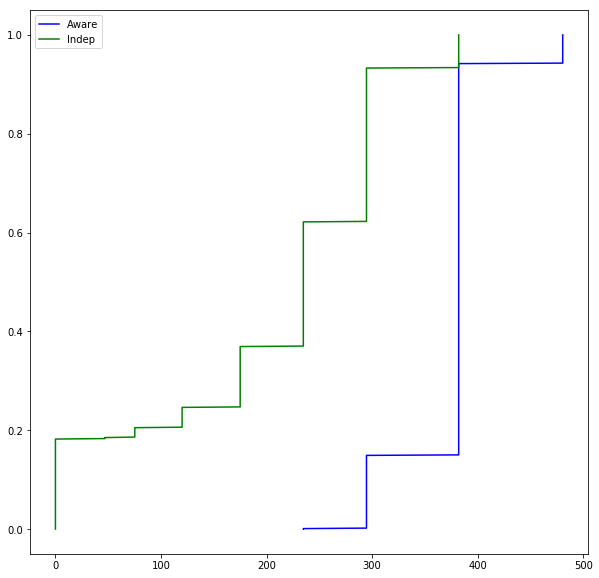

In [4]:
CDF(aware_rate,'b',"Aware")
CDF(norm_rate,'g',"Indep")
plt.legend()
plt.show()

## References
* LTE Throughput calculations : [Paper by Babkin et al](http://iot.sut.ru/08.pdf)